% This notebook is generated by Shaojie Yang from Center of IMS University of Cincinnati. 

Objective: 

Data augmentation methodology for wafer map fault patterns image dataset to
increase the diversity and quantity of image for CNN classification acurracy improvement

Step 1: Prepare the data

In [17]:
!jt -t grade3

In [1]:
from __future__ import print_function
%matplotlib inline
import os
from os.path import join
import numpy
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

path = os.chdir(r'D:/OneDrive - University of Cincinnati/Wafer Map/input')
datapath = join('data', 'wafer')
print(os.listdir("../input"))
import warnings
warnings.filterwarnings("ignore")

['LSWMD.pkl']


In [2]:
# Data Summary
df=pd.read_pickle("../input/LSWMD.pkl")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 811457 entries, 0 to 811456
Data columns (total 6 columns):
waferMap          811457 non-null object
dieSize           811457 non-null float64
lotName           811457 non-null object
waferIndex        811457 non-null float64
trianTestLabel    811457 non-null object
failureType       811457 non-null object
dtypes: float64(2), object(4)
memory usage: 37.1+ MB


In [3]:
df.head()

,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,1.0,[[Training]],[[none]]
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,2.0,[[Training]],[[none]]
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,3.0,[[Training]],[[none]]
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,4.0,[[Training]],[[none]]
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,5.0,[[Training]],[[none]]


In [4]:
df.tail()

,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType
811452,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47542,23.0,[[Test]],[[Edge-Ring]]
811453,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1,...",600.0,lot47542,24.0,[[Test]],[[Edge-Loc]]
811454,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47542,25.0,[[Test]],[[Edge-Ring]]
811455,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,...",600.0,lot47543,1.0,[],[]
811456,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47543,2.0,[],[]


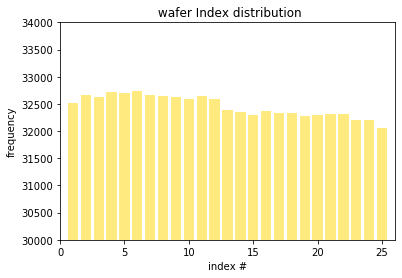

In [5]:
uni_Index=np.unique(df.waferIndex, return_counts=True)
plt.bar(uni_Index[0],uni_Index[1], color='gold', align='center', alpha=0.5)
plt.title(" wafer Index distribution")
plt.xlabel("index #")
plt.ylabel("frequency")
plt.xlim(0,26)
plt.ylim(30000,34000)
plt.show()

In [6]:
df = df.drop(['waferIndex'], axis = 1)
def find_dim(x):
    dim0=np.size(x,axis=0)
    dim1=np.size(x,axis=1)
    return dim0,dim1
df['waferMapDim']=df.waferMap.apply(find_dim)
df.sample(5)

,waferMap,dieSize,lotName,trianTestLabel,failureType,waferMapDim
288012,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2367.0,lot17603,[],[],"(51, 59)"
351855,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1057.0,lot20975,[],[],"(37, 37)"
8682,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 1, 2, 2,...",520.0,lot1640,[],[],"(26, 26)"
647068,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1, 1, 1,...",533.0,lot40627,[],[],"(26, 26)"
621041,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1513.0,lot39034,[],[],"(49, 39)"


In [7]:
max(df.waferMapDim), min(df.waferMapDim)

((300, 202), (6, 21))

In [8]:
uni_waferDim=np.unique(df.waferMapDim, return_counts=True)
uni_waferDim[0].shape[0]

632

In [9]:
tol_wafers = df.shape[0]
tol_wafers

811457

In [10]:
# Check Missing Value
df['failureNum']=df.failureType
df['trainTestNum']=df.trianTestLabel
mapping_type={'Center':0,'Donut':1,'Edge-Loc':2,'Edge-Ring':3,'Loc':4,'Random':5,'Scratch':6,'Near-full':7,'none':8}
mapping_traintest={'Training':0,'Test':1}
df=df.replace({'failureNum':mapping_type, 'trainTestNum':mapping_traintest})
df_withlabel = df[(df['failureNum']>=0) & (df['failureNum']<=8)]
df_withlabel =df_withlabel.reset_index()
df_withpattern = df[(df['failureNum']>=0) & (df['failureNum']<=7)]
df_withpattern = df_withpattern.reset_index()
df_nonpattern = df[(df['failureNum']==8)]
df_withlabel.shape[0], df_withpattern.shape[0], df_nonpattern.shape[0]

(172950, 25519, 147431)

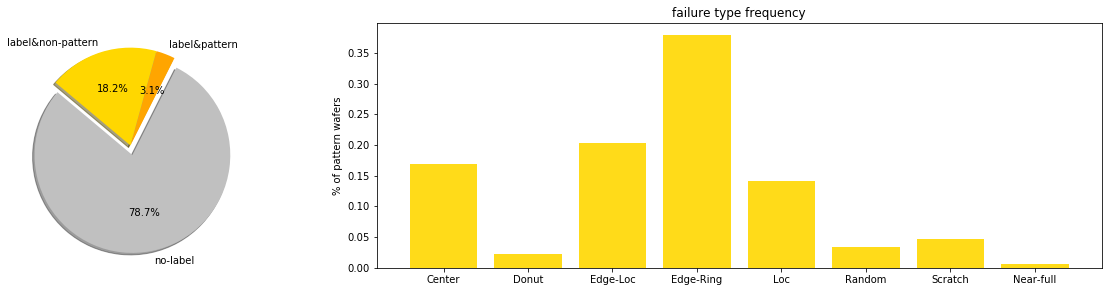

In [11]:
from matplotlib import gridspec
fig = plt.figure(figsize=(20, 4.5)) 
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 2.5]) 
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

no_wafers=[tol_wafers-df_withlabel.shape[0], df_withpattern.shape[0], df_nonpattern.shape[0]]

colors = ['silver', 'orange', 'gold']
explode = (0.1, 0, 0)  # explode 1st slice
labels = ['no-label','label&pattern','label&non-pattern']
ax1.pie(no_wafers, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)

uni_pattern=np.unique(df_withpattern.failureNum, return_counts=True)
labels2 = ['','Center','Donut','Edge-Loc','Edge-Ring','Loc','Random','Scratch','Near-full']
ax2.bar(uni_pattern[0],uni_pattern[1]/df_withpattern.shape[0], color='gold', align='center', alpha=0.9)
ax2.set_title("failure type frequency")
ax2.set_ylabel("% of pattern wafers")
ax2.set_xticklabels(labels2)

plt.show()

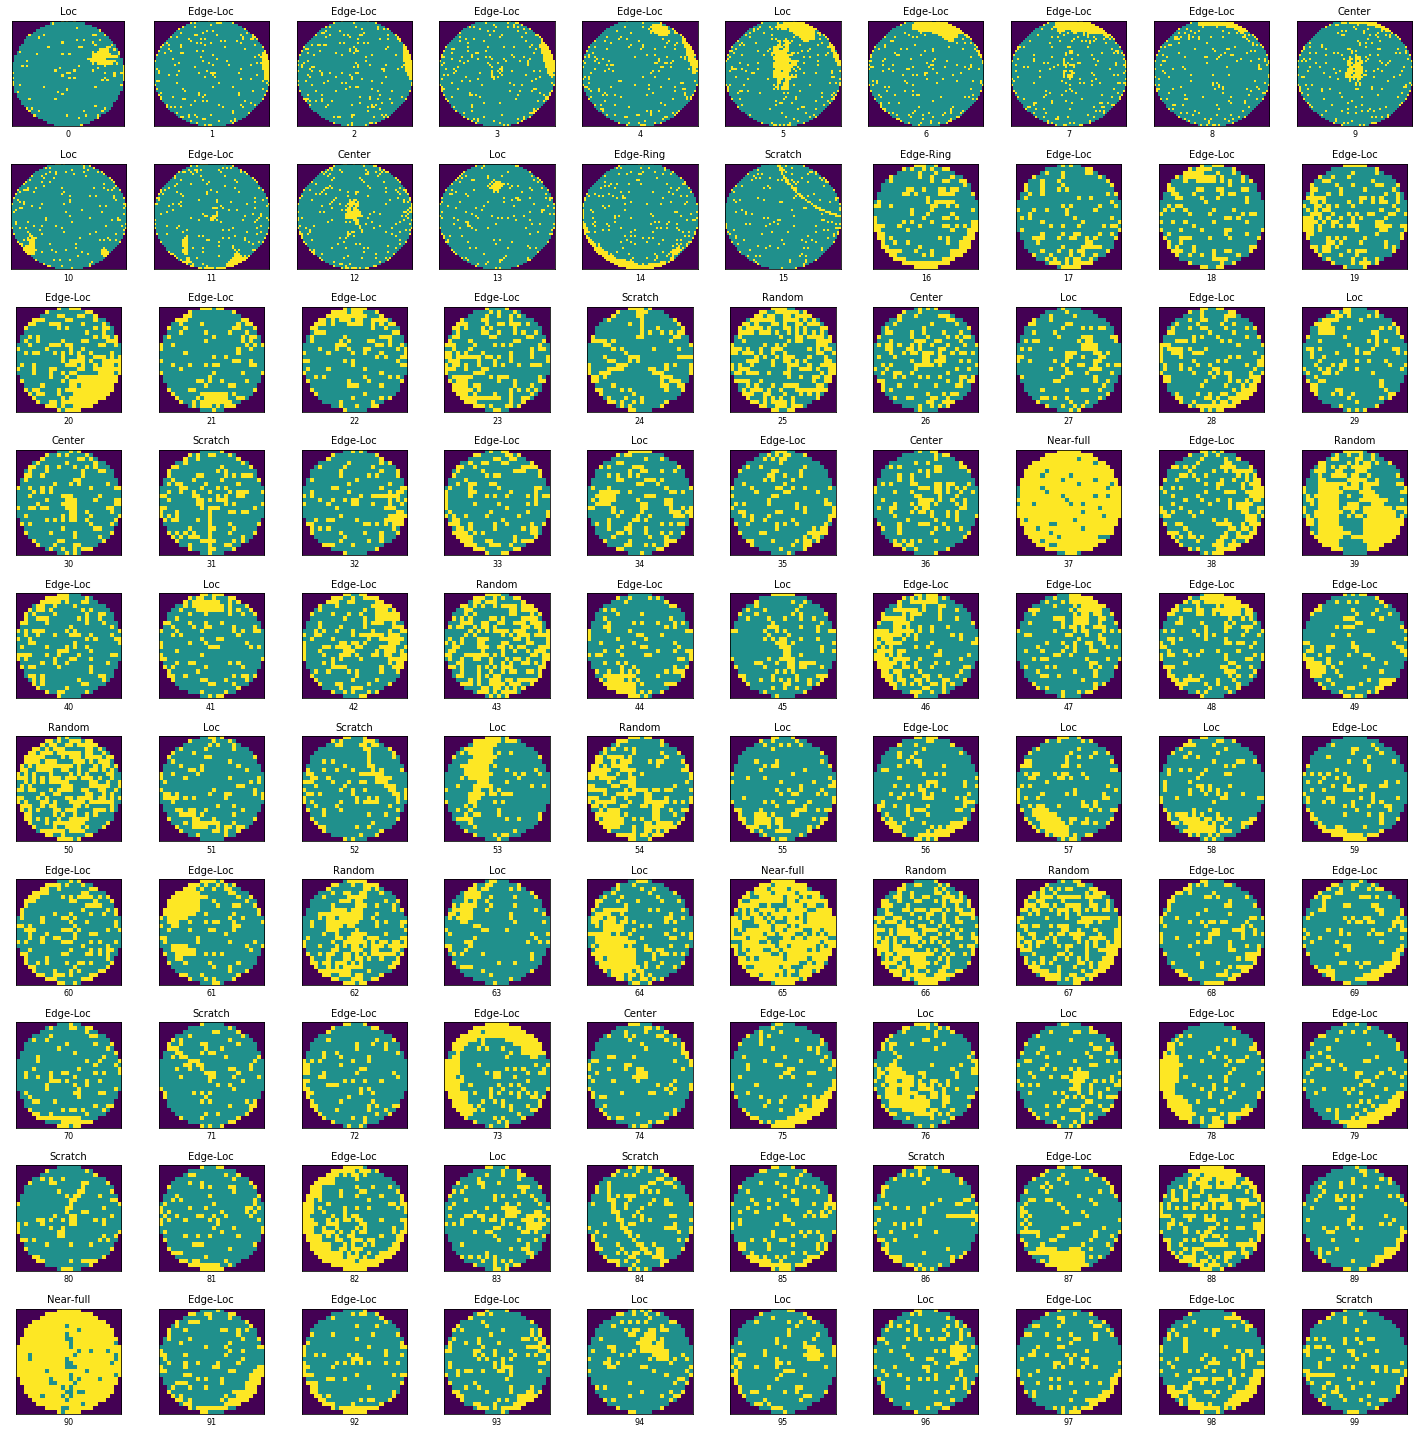

In [12]:
fig, ax = plt.subplots(nrows = 10, ncols = 10, figsize=(20, 20))
ax = ax.ravel(order='C')
for i in range(100):
    img = df_withpattern.waferMap[i]
    ax[i].imshow(img)
    ax[i].set_title(df_withpattern.failureType[i][0][0], fontsize=10)
    ax[i].set_xlabel(df_withpattern.index[i], fontsize=8)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
plt.tight_layout()
plt.show() 

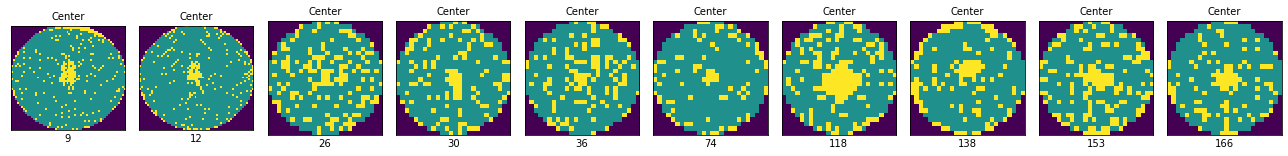

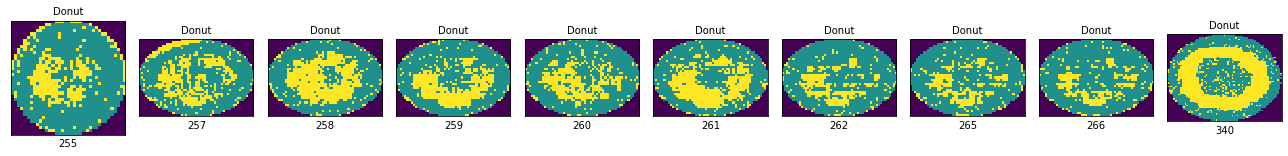

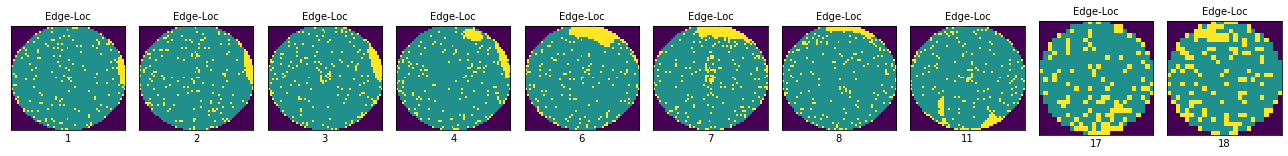

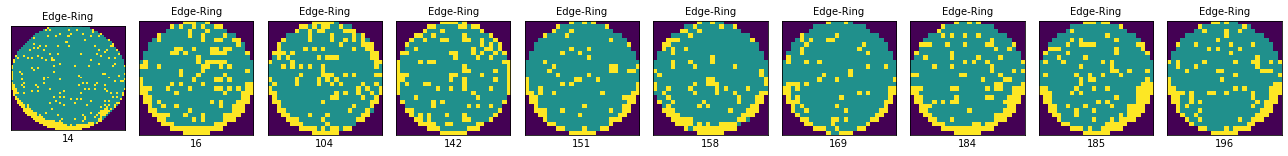

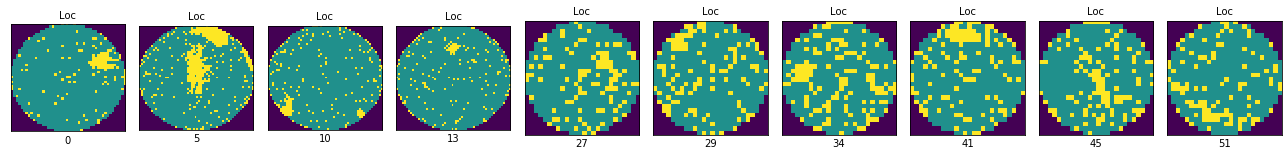

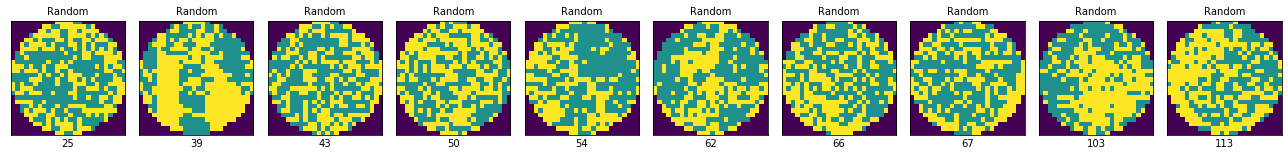

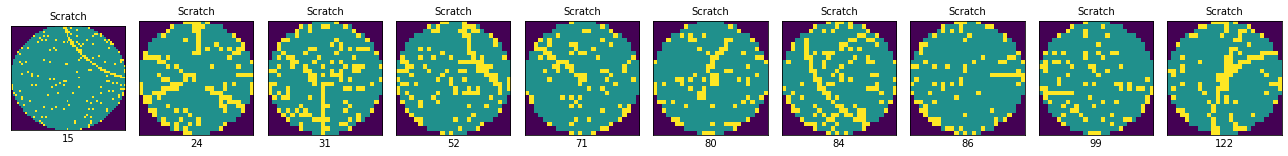

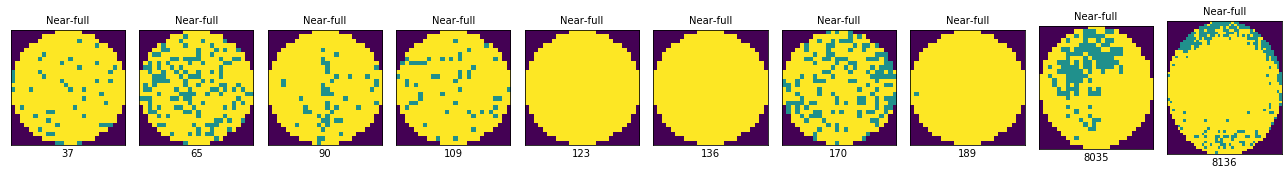

In [13]:
x = [0,1,2,3,4,5,6,7]
labels2 = ['Center','Donut','Edge-Loc','Edge-Ring','Loc','Random','Scratch','Near-full']

for k in x:
    fig, ax = plt.subplots(nrows = 1, ncols = 10, figsize=(18, 12))
    ax = ax.ravel(order='C')
    for j in [k]:
        img = df_withpattern.waferMap[df_withpattern.failureType==labels2[j]]
        for i in range(10):
            ax[i].imshow(img[img.index[i]])
            ax[i].set_title(df_withpattern.failureType[img.index[i]][0][0], fontsize=10)
            ax[i].set_xlabel(df_withpattern.index[img.index[i]], fontsize=10)
            ax[i].set_xticks([])
            ax[i].set_yticks([])
    plt.tight_layout()
    plt.show() 

In [14]:
def find_dim(x):
    dim0=np.size(x,axis=0)
    dim1=np.size(x,axis=1)
    return dim0,dim1
df['waferMapDim']=df.waferMap.apply(find_dim)
df.sample(5)

,waferMap,dieSize,lotName,trianTestLabel,failureType,waferMapDim,failureNum,trainTestNum
707218,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 2,...",516.0,lot43314,[[Training]],[[none]],"(25, 27)",8,0
606353,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,...",710.0,lot38186,[],[],"(32, 29)",[],[]
294895,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",15550.0,lot18039,[],[],"(135, 146)",[],[]
516139,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 2, 1,...",515.0,lot32242,[],[],"(25, 27)",[],[]
65657,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 2, 1, 1,...",682.0,lot5004,[],[],"(31, 28)",[],[]


In [15]:
# Select wafer dimension 26x26 for this study
sub_df = df.loc[df['waferMapDim'] == (26, 26)]
sub_wafer = sub_df['waferMap'].values

sw = np.ones((1, 26, 26))
label = list()

for i in range(len(sub_df)):
    # skip null label
    if len(sub_df.iloc[i,:]['failureType']) == 0:
        continue
    sw = np.concatenate((sw, sub_df.iloc[i,:]['waferMap'].reshape(1, 26, 26)))
    label.append(sub_df.iloc[i,:]['failureType'][0][0])

In [19]:
x = sw[1:]
y = np.array(label).reshape((-1,1))

In [20]:
# check dimension
print('x shape : {}, y shape : {}'.format(x.shape, y.shape))

x shape : (14366, 26, 26), y shape : (14366, 1)


In [21]:
# Check the amount of wafer in each class
faulty_case = np.unique(y)
for f in faulty_case :
    print('{} : {}'.format(f, len(y[y==f])))

Center : 90
Donut : 1
Edge-Loc : 296
Edge-Ring : 31
Loc : 297
Near-full : 16
Random : 74
Scratch : 72
none : 13489


In [22]:
# Delete class Donut, because there is only one Donut image
none_idx = np.where(y=='Donut')[0][np.random.choice(len(np.where(y=='Donut')[0]), size=1, replace=False)]
y = np.delete(y, none_idx, axis=0)
x = np.delete(x, none_idx, axis=0)

In [23]:
x, Xtest, y, Ytest = train_test_split(x, y, test_size=0.1, random_state=42)

In [24]:
# Original Training dataset
faulty_case = np.unique(y)
for f in faulty_case :
    print('{} : {}'.format(f, len(y[y==f])))

Center : 85
Edge-Loc : 262
Edge-Ring : 23
Loc : 270
Near-full : 13
Random : 65
Scratch : 62
none : 12148


In [25]:
# Test dataset
faulty_case = np.unique(Ytest)
for f in faulty_case :
    print('{} : {}'.format(f, len(Ytest[Ytest==f])))

Center : 5
Edge-Loc : 34
Edge-Ring : 8
Loc : 27
Near-full : 3
Random : 9
Scratch : 10
none : 1341


In [26]:
# delete extra none from training and test
none_idx = np.where(y=='none')[0][np.random.choice(len(np.where(y=='none')[0]), size=11000, replace=False)]
y = np.delete(y, none_idx, axis=0)
x = np.delete(x, none_idx, axis=0)

none_idx = np.where(Ytest=='none')[0][np.random.choice(len(np.where(Ytest=='none')[0]), size=1200, replace=False)]
Ytest = np.delete(Ytest, none_idx, axis=0)
Xtest = np.delete(Xtest, none_idx, axis=0)

Step 2: Data Augmentation

In [27]:
import random
from scipy import ndarray

# image processing library
import skimage as sk
from skimage import transform

In [28]:
def random_rotation(image_array: ndarray):
    # pick a random degree of rotation between 25% on the left and 25% on the right
    random_degree = random.uniform(-30, 30)
    return sk.transform.rotate(image_array, random_degree)

def random_noise(image_array: ndarray):
    # add random noise to the image
    return sk.util.random_noise(image_array,mode='gaussian')

def horizontal_flip(image_array: ndarray):
    # horizontal flip doesn't need skimage, it's easy as flipping the image array of pixels !
    return image_array[:, ::-1]

def vertical_flip(image_array: ndarray):
    # horizontal flip doesn't need skimage, it's easy as flipping the image array of pixels !
    return image_array[::-1, :]



# dictionary of the transformations we defined earlier
available_transformations = {
    'rotate': random_rotation,
    #'noise': random_noise,
    'horizontal_flip': horizontal_flip,
    'vertical_flip': vertical_flip,}

In [29]:
# geometric transformation samples

image_to_transform_a = random.choice(x)  
num_transformations_to_apply = random.randint(1, len(available_transformations))
num_transformations = 0
transformed_image = None
while num_transformations <= num_transformations_to_apply:
    # random transformation to apply for a single image
    key = random.choice(list(available_transformations))
    transformed_image_a = available_transformations[key](image_to_transform_a)
    num_transformations += 1

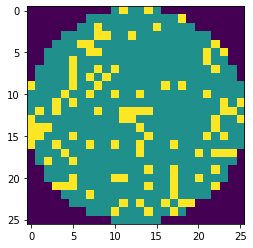

In [30]:
plt.imshow(image_to_transform_a)
plt.show()

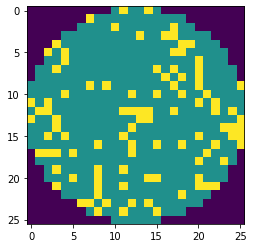

In [31]:
plt.imshow(transformed_image_a)
plt.show()

In [32]:
# Generate Data

def gen_data(wafer, label):
    # Encode input wafer
    gen_x = np.zeros((1, 26, 26))
    for i in range(1000):
        image_to_transform = random.choice(wafer)  
        num_transformations_to_apply = random.randint(1, len(available_transformations))
        num_transformations = 0
        transformed_image = None
        while num_transformations <= num_transformations_to_apply:
            # random transformation to apply for a single image
            key = random.choice(list(available_transformations))
            transformed_image = available_transformations[key](image_to_transform)
            num_transformations += 1
        transformed_image = transformed_image.reshape((1, 26, 26))
        gen_x = np.concatenate((gen_x, transformed_image), axis=0)
    gen_y = np.full((len(gen_x), 1), label)
    # return date without 1st dummy data.
    return gen_x[1:], gen_y[1:]

In [33]:
# Augmentation for all faulty case.
faulty_case = np.unique(y)


for f in faulty_case : 
    # skip none case
    if f == 'none' : 
        continue
    
    gen_x, gen_y = gen_data(x[np.where(y==f)[0]], f)
    x = np.concatenate((x, gen_x), axis=0)
    y = np.concatenate((y, gen_y))    

In [34]:
# Training dataset after data augmentation
faulty_case = np.unique(y)
for f in faulty_case :
    print('{} : {}'.format(f, len(y[y==f])))

Center : 1085
Edge-Loc : 1262
Edge-Ring : 1023
Loc : 1270
Near-full : 1013
Random : 1065
Scratch : 1062
none : 1148


In [35]:
x = x.reshape((-1, 26, 26, 1))
def set_labels(sample):
    labels = []
    for i in range(len(sample)):
        if 'Scratch' in sample[i]:
            labels.append([1,0,0,0,0,0,0,0])
        elif 'Center' in sample[i]:
            labels.append([0,1,0,0,0,0,0,0])
        elif 'Edge-Loc' in sample[i]:
            labels.append([0,0,1,0,0,0,0,0])
        elif 'Edge-Ring' in sample[i]:
            labels.append([0,0,0,1,0,0,0,0])
        elif 'Loc' in sample[i]:
            labels.append([0,0,0,0,1,0,0,0])
        elif 'Near-full' in sample[i]:
            labels.append([0,0,0,0,0,1,0,0])
        elif 'Random' in sample[i]:
            labels.append([0,0,0,0,0,0,1,0])
        elif 'none' in sample[i]:
            labels.append([0,0,0,0,0,0,0,1])
    return labels
label_revers = set_labels(y)

Ytrain = np.array(label_revers)

label_revers = set_labels(Ytest)

Ytest = np.array(label_revers)
Xtrain = x

In [36]:
Xtest = Xtest.reshape(Xtest.shape[0],Xtest.shape[1],Xtest.shape[2],1)/255
Xtrain = Xtrain.reshape(Xtrain.shape[0],Xtrain.shape[1],Xtrain.shape[2],1)/255

Step 3: CNN Classification

In [41]:
# CNN model
def softplus(x):
     xp = np.get_array_module(x)
     return np.maximum(0, x) + xp.log1p(xp.exp(-abs(x)))

# def create_model():
from tensorflow.keras.layers import LeakyReLU
model = Sequential()

# aaa = 0.3
model.add(Conv2D(32, (3, 3), activation='relu',  input_shape=(26, 26, 1)))
model.add(Dropout(0.5))
model.add(Conv2D(16, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))
model.add(Conv2D(16, (3, 3), activation='relu'))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(8, activation='softmax'))
sgd_opt = tensorflow.keras.optimizers.Adam(lr=0.0001)
model.compile(loss='categorical_crossentropy',
            optimizer=sgd_opt,
            metrics=['accuracy'])
history = model.fit(Xtrain, Ytrain, batch_size=25, epochs=50, verbose=1, validation_data=(Xtest, Ytest))
score = model.evaluate(Xtest, Ytest, batch_size=25, verbose=0)
print('Test accuracy:', score[1])

loss_history = history.history['loss']
numpy_loss_history = np.array(loss_history)

accuracy_history = history.history['accuracy']
numpy_accuracy_history = np.array(accuracy_history)

val_loss_history = history.history['val_loss']
numpy_val_loss_history = np.array(val_loss_history)

val_accuracy_history = history.history['val_accuracy']
numpy_val_accuracy_history = np.array(val_accuracy_history)

model.summary()

Epoch 1/50
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
334/358 [==========================>...] - ETA: 0s - loss: 2.0410 - accuracy: 0.1678WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x0000029CF0692CA8> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`

Step 4: Results

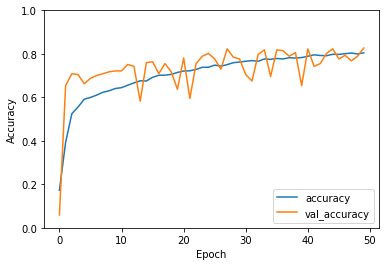

In [42]:
f = plt.figure(1)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

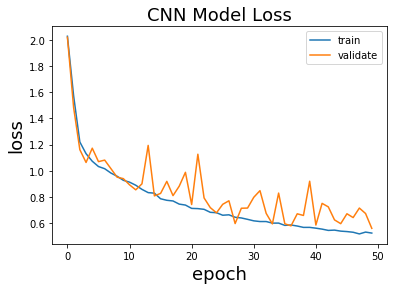

In [43]:
g = plt.figure(2)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.title('CNN Model Loss', fontsize=18)
plt.ylabel('loss', fontsize=18)
plt.xlabel('epoch', fontsize=18)
plt.legend(['train', 'validate'], loc='upper right')

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


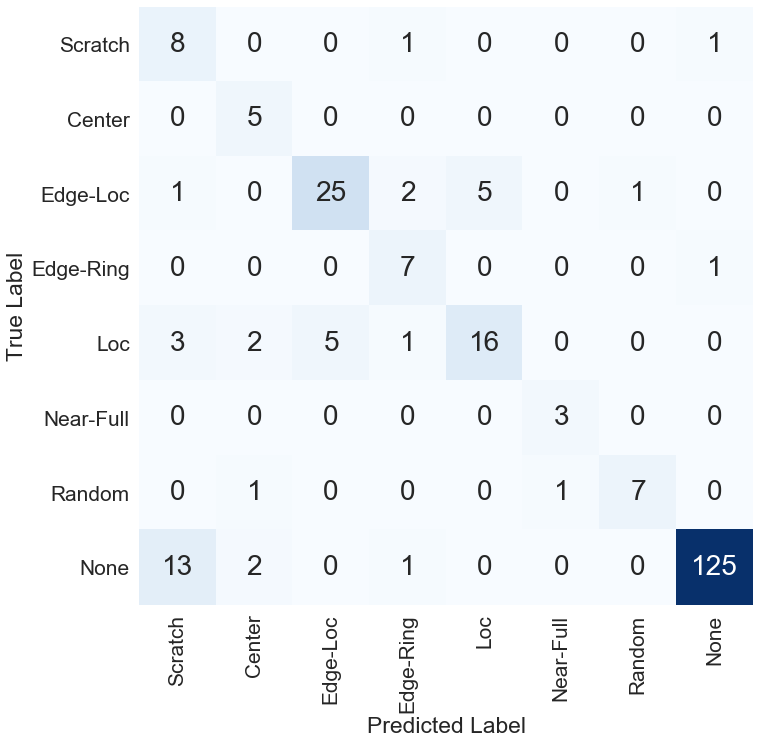

In [44]:
# Plot confusion matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

Ytest = np.argmax(Ytest, axis=1)
y_pred = model.predict(Xtest)

y_pred = np.argmax(y_pred, axis=1)

cm = confusion_matrix(Ytest, y_pred)

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

y_true = ["Scratch", "Center", "Edge-Loc", "Edge-Ring", "Loc", "Near-Full", "Random", "None"]
cm = pd.DataFrame(cm, columns=y_true, index = y_true)
cm.index.name = 'True Label'
cm.columns.name = 'Predicted Label'
plt.figure(figsize = (11,11))
sns.set(font_scale=1.9)#for label size
f = sns.heatmap(cm, cmap="Blues", annot=True,annot_kws={"size": 28},fmt="d",cbar=False)